# Music Genre Classification Project

In [240]:
import pandas as pd
import numpy as np

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import category_scatter
plt.style.use('fivethirtyeight')

# this statement allows the visuals to render within your Jupyter Notebook
%matplotlib inline

from sqlalchemy import create_engine

# modeling imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

### Use SQLite to manage large csv and only grab relevant features

In [6]:
# convert csv to a table without pandas
# with pandas look like:
# pd.read_csv('spotify_songs_3yrs.csv').to_sql('spotify_songs_3yrs', engine, if_exists='append', index=False)
import subprocess
from pathlib import Path
db_name = Path('tcc_ceds_music.db').resolve()
csv_file = Path('tcc_ceds_music.csv').resolve()
result = subprocess.run(['sqlite3',
                         str(db_name),
                         '-cmd',
                         '.mode csv',
                         '.import ' + str(csv_file).replace('\\','\\\\')
                                 +' tcc_ceds_music'],
                        capture_output=True)

In [7]:
engine = create_engine("sqlite:///tcc_ceds_music.db")

songs_df = pd.read_sql("SELECT genre, artist_name, track_name, release_date, \
                        danceability, loudness, acousticness, instrumentalness, \
                        valence, energy, \
                        dating, violence, [world/life], [night/time], [shake the audience], \
                        [family/gospel], romantic, communication, obscene, music, \
                        [movement/places], [light/visual perceptions], [family/spiritual], \
                        [like/girls], sadness, feelings \
                        FROM tcc_ceds_music;",
                       engine)

In [8]:
songs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28372 entries, 0 to 28371
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   genre                     28372 non-null  object
 1   artist_name               28372 non-null  object
 2   track_name                28372 non-null  object
 3   release_date              28372 non-null  object
 4   danceability              28372 non-null  object
 5   loudness                  28372 non-null  object
 6   acousticness              28372 non-null  object
 7   instrumentalness          28372 non-null  object
 8   valence                   28372 non-null  object
 9   energy                    28372 non-null  object
 10  dating                    28372 non-null  object
 11  violence                  28372 non-null  object
 12  world/life                28372 non-null  object
 13  night/time                28372 non-null  object
 14  shake the audience    

In [90]:
songs_df.loc[:, 'genre'].str.strip()

0            pop
1            pop
2            pop
3            pop
4            pop
          ...   
28367    hip hop
28368    hip hop
28369    hip hop
28370    hip hop
28371    hip hop
Name: genre, Length: 28372, dtype: string

In [92]:
songs_df.genre.str.encode('utf-8')

0            b'pop'
1            b'pop'
2            b'pop'
3            b'pop'
4            b'pop'
            ...    
28367    b'hip hop'
28368    b'hip hop'
28369    b'hip hop'
28370    b'hip hop'
28371    b'hip hop'
Name: genre, Length: 28372, dtype: object

In [10]:
songs_df.rename(columns = {"world/life": "world_life", "night/time": "night_time", 
                           "shake the audience": "shake_the_audience", "family/gospel": "family_gospel",
                           "movement/places": "movement_places", "light/visual perceptions": "light_visual",
                           "family/spiritual": "family_spiritual", "like/girls": "like_girls"}, 
                inplace=True)

In [11]:
songs_df[['danceability', 'loudness', 'acousticness', 'instrumentalness', 'valence', 'energy',
          'dating', 'violence', 'world_life', 'night_time', 'shake_the_audience', 'family_gospel', 
          'romantic', 'communication', 'obscene', 'music', 'movement_places', 'light_visual', 
          'family_spiritual', 'like_girls', 'sadness', 
          'feelings']] = songs_df[['danceability', 'loudness', 'acousticness', 'instrumentalness', 'valence', 
                                   'energy', 'dating', 'violence', 'world_life', 'night_time', 
                                   'shake_the_audience', 'family_gospel', 'romantic', 'communication', 
                                   'obscene', 'music', 'movement_places', 'light_visual', 'family_spiritual', 
                                   'like_girls', 'sadness', 
                                   'feelings']].apply(pd.to_numeric, errors='coerce')

In [12]:
songs_df = songs_df.convert_dtypes()

In [223]:
songs_df['release_date'] = pd.to_numeric(songs_df['release_date'])

In [224]:
songs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28372 entries, 0 to 28371
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   genre               28372 non-null  string 
 1   artist_name         28372 non-null  string 
 2   track_name          28372 non-null  string 
 3   release_date        28372 non-null  int64  
 4   danceability        28372 non-null  Float64
 5   loudness            28372 non-null  Float64
 6   acousticness        28372 non-null  Float64
 7   instrumentalness    28372 non-null  Float64
 8   valence             28372 non-null  Float64
 9   energy              28372 non-null  Float64
 10  dating              28372 non-null  Float64
 11  violence            28372 non-null  Float64
 12  world_life          28372 non-null  Float64
 13  night_time          28372 non-null  Float64
 14  shake_the_audience  28372 non-null  Float64
 15  family_gospel       28372 non-null  Float64
 16  roma

In [16]:
songs_df.genre.value_counts()

pop        7042
country    5445
blues      4604
rock       4034
jazz       3845
reggae     2498
hip hop     904
Name: genre, dtype: Int64

In [29]:
# check for duplicate artist/track data entries
multiples = songs_df.groupby(by=['artist_name', 'track_name'], as_index=False)[['artist_name', 'track_name']].count()
multiples.value_counts()

artist_name  track_name
1            1             28372
dtype: int64

In [100]:
X_train, X_test, y_train, y_test = train_test_split(songs_df.iloc[:, 4:], songs_df.iloc[:, 0], 
                                                    test_size = 0.2, random_state=42)

train_df = X_train.copy()
train_df['genre'] = y_train
train_df.head()

,danceability,loudness,acousticness,instrumentalness,valence,energy,dating,violence,world_life,night_time,...,communication,obscene,music,movement_places,light_visual,family_spiritual,like_girls,sadness,feelings,genre
12548,0.334994,0.586416,0.661646,0.0,0.73413,0.184159,0.071918,0.001754,0.089264,0.001754,...,0.001754,0.001754,0.151184,0.001754,0.078814,0.001754,0.048103,0.001754,0.001754,blues
8688,0.64042,0.594749,0.034236,0.078846,0.913438,0.806801,0.001284,0.001284,0.001284,0.037079,...,0.001284,0.368926,0.001284,0.327426,0.079822,0.001284,0.091989,0.001284,0.001284,country
17255,0.637171,0.561034,0.829317,0.0,0.705276,0.187162,0.000797,0.000797,0.625575,0.017597,...,0.000797,0.000797,0.052347,0.044205,0.082851,0.000797,0.000797,0.000797,0.000797,jazz
3737,0.262428,0.612286,0.773092,0.000001,0.291014,0.330309,0.00277,0.110237,0.572767,0.00277,...,0.00277,0.00277,0.00277,0.00277,0.118842,0.00277,0.00277,0.00277,0.00277,pop
19343,0.585184,0.718381,0.306224,0.003229,0.806265,0.691682,0.004386,0.004386,0.004386,0.004386,...,0.004386,0.004386,0.004386,0.004386,0.004386,0.004386,0.004386,0.004386,0.921053,jazz


In [128]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22697 entries, 12548 to 23654
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   danceability        22697 non-null  Float64
 1   loudness            22697 non-null  Float64
 2   acousticness        22697 non-null  Float64
 3   instrumentalness    22697 non-null  Float64
 4   valence             22697 non-null  Float64
 5   energy              22697 non-null  Float64
 6   dating              22697 non-null  Float64
 7   violence            22697 non-null  Float64
 8   world_life          22697 non-null  Float64
 9   night_time          22697 non-null  Float64
 10  shake_the_audience  22697 non-null  Float64
 11  family_gospel       22697 non-null  Float64
 12  romantic            22697 non-null  Float64
 13  communication       22697 non-null  Float64
 14  obscene             22697 non-null  Float64
 15  music               22697 non-null  Float64
 16  

ValueError: object arrays are not supported

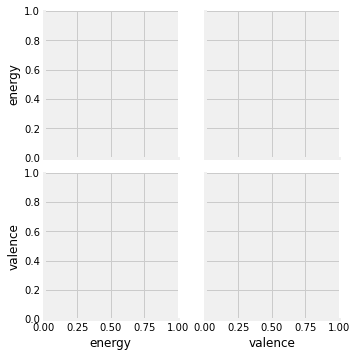

In [127]:
# this won't work with genre as the hue - it says object arrays not supported
sns.pairplot(train_df,
             hue='genre',
             vars = ['danceability', 'loudness', 'acousticness', 'instrumentalness', 'valence', 'energy']
            );

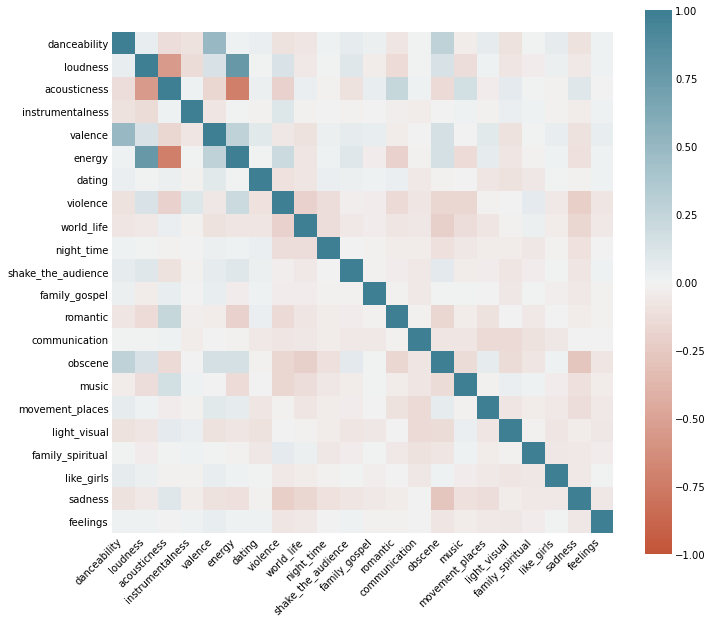

In [131]:
# try making a correlation matrix heatmap
corr = train_df.corr()
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(corr, vmin=-1, vmax=1, center=0,
                 cmap=sns.diverging_palette(20, 220, n=200),
                 square=True, ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

In [ ]:
corr_target = abs(corr["genre"])
relevant_features = corr_target[cor_target>0.1]
relevant_features

<AxesSubplot:>

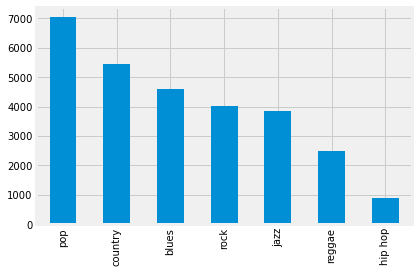

In [82]:
songs_df['genre'].value_counts().plot(kind='bar')

/home/melissa/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


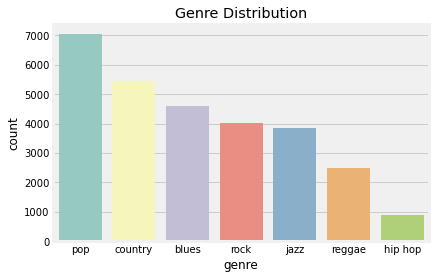

In [83]:
sns.countplot(songs_df['genre'],
              order = songs_df['genre'].value_counts().index,
              palette = "Set3"
             ).set(title='Genre Distribution');

<ipython-input-84-1bf53c194c3a>:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


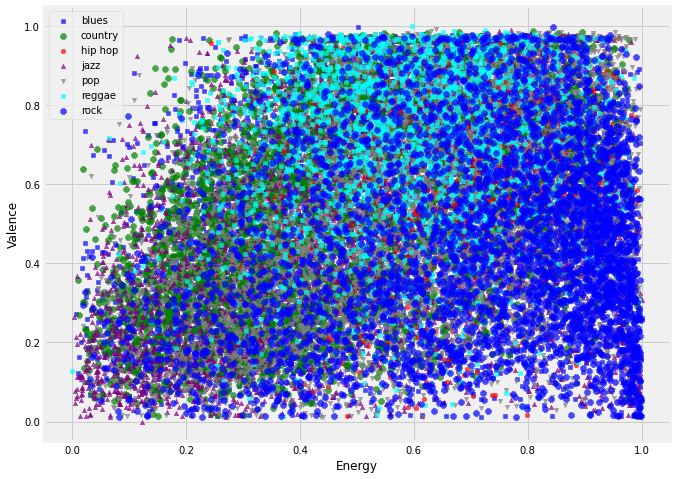

In [84]:
fig = category_scatter(x='energy', y='valence', label_col='genre',
                       data=songs_df, legend_loc='upper right')
fig.set_size_inches(10, 8)
plt.xlabel('Energy')
plt.ylabel('Valence')
plt.legend()
fig.show();

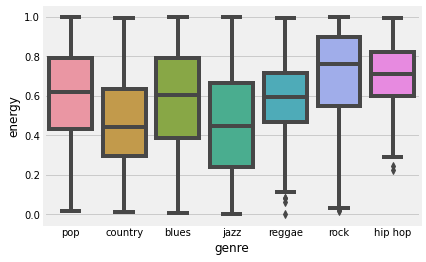

In [85]:
sns.boxplot(x = 'genre', y = 'energy', data = songs_df);

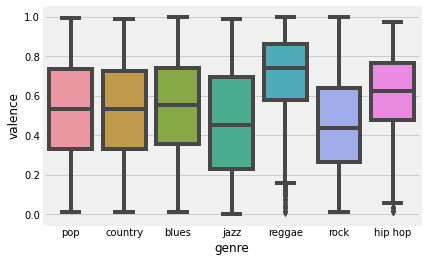

In [86]:
sns.boxplot(x = 'genre', y = 'valence', data = songs_df);

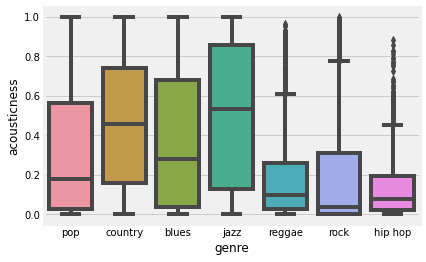

In [139]:
sns.boxplot(x = 'genre', y = 'acousticness', data = songs_df);

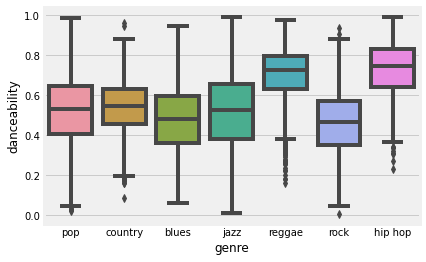

In [140]:
sns.boxplot(x = 'genre', y = 'danceability', data = songs_df);

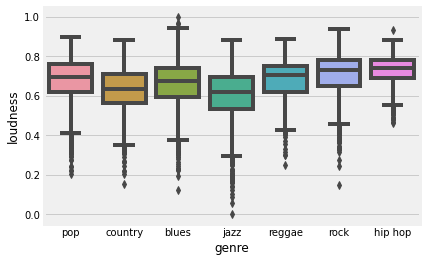

In [141]:
sns.boxplot(x = 'genre', y = 'loudness', data = songs_df);

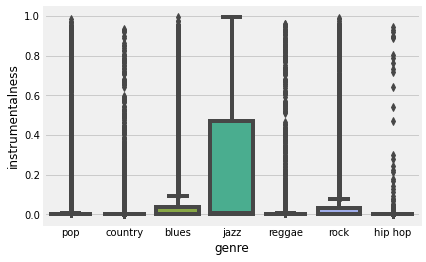

In [142]:
sns.boxplot(x = 'genre', y = 'instrumentalness', data = songs_df);

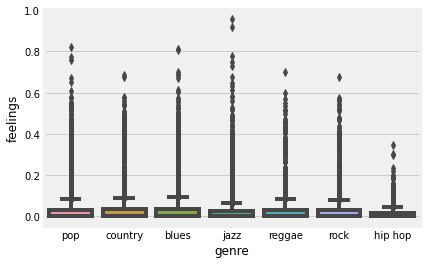

In [143]:
sns.boxplot(x = 'genre', y = 'feelings', data = songs_df);

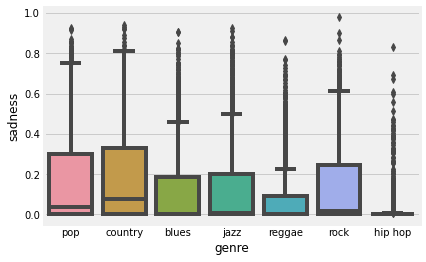

In [144]:
sns.boxplot(x = 'genre', y = 'sadness', data = songs_df);

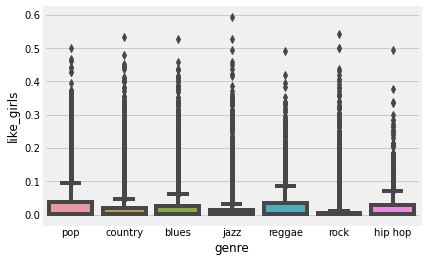

In [145]:
sns.boxplot(x = 'genre', y = 'like_girls', data = songs_df);

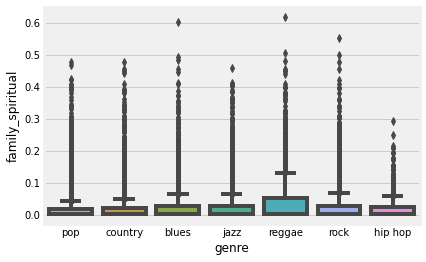

In [146]:
sns.boxplot(x = 'genre', y = 'family_spiritual', data = songs_df);

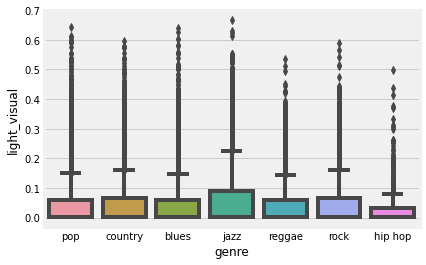

In [147]:
sns.boxplot(x = 'genre', y = 'light_visual', data = songs_df);

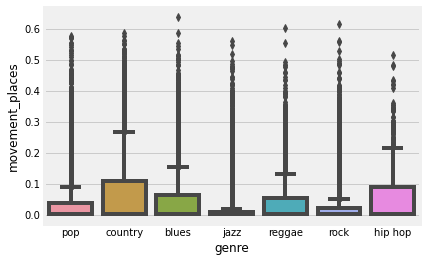

In [148]:
sns.boxplot(x = 'genre', y = 'movement_places', data = songs_df);

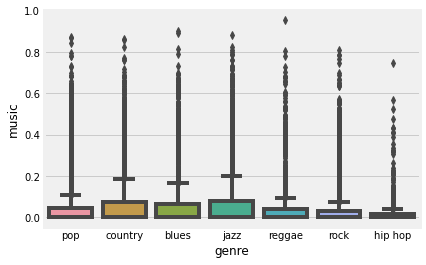

In [149]:
sns.boxplot(x = 'genre', y = 'music', data = songs_df);

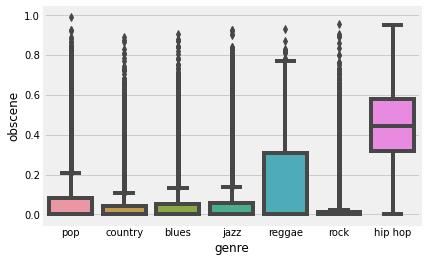

In [150]:
sns.boxplot(x = 'genre', y = 'obscene', data = songs_df);

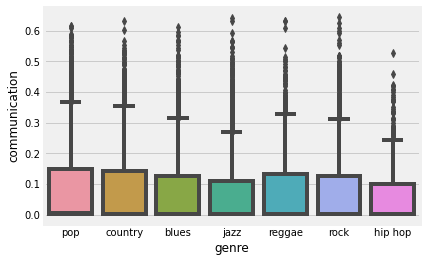

In [151]:
sns.boxplot(x = 'genre', y = 'communication', data = songs_df);

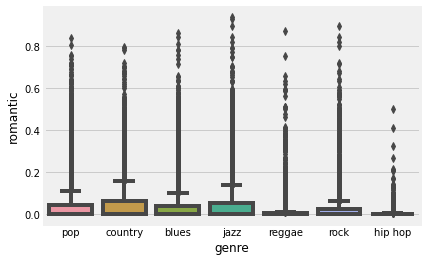

In [152]:
sns.boxplot(x = 'genre', y = 'romantic', data = songs_df);

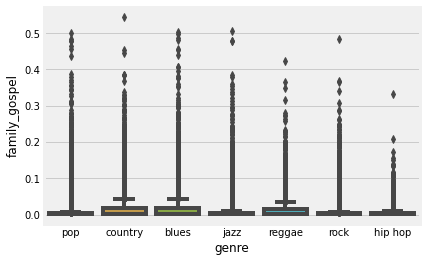

In [153]:
sns.boxplot(x = 'genre', y = 'family_gospel', data = songs_df);

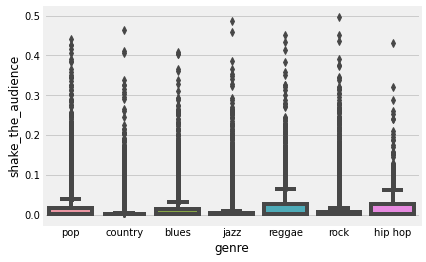

In [154]:
sns.boxplot(x = 'genre', y = 'shake_the_audience', data = songs_df);

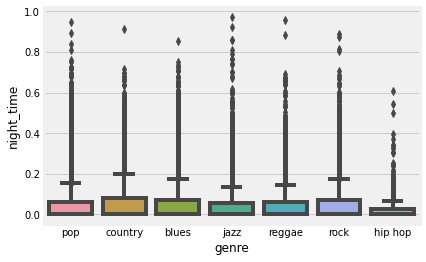

In [155]:
sns.boxplot(x = 'genre', y = 'night_time', data = songs_df);

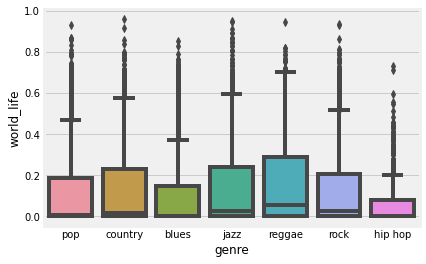

In [156]:
sns.boxplot(x = 'genre', y = 'world_life', data = songs_df);

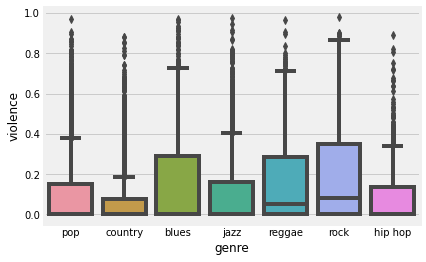

In [157]:
sns.boxplot(x = 'genre', y = 'violence', data = songs_df);

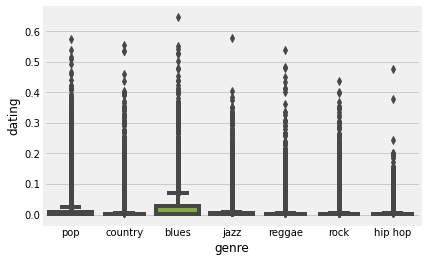

In [158]:
sns.boxplot(x = 'genre', y = 'dating', data = songs_df);

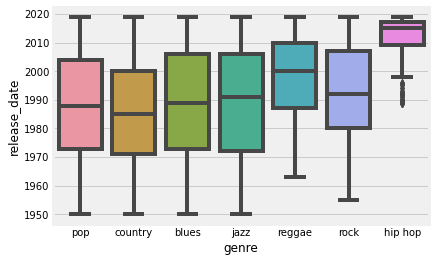

In [225]:
sns.boxplot(x = 'genre', y = 'release_date', data = songs_df);

## Baselining

#### Build simple baseline models using:
- kNN
- multinomial logistic regression
- random forest

In [125]:
# Knn with just 2 features for baselining
X_train2 = X_train.iloc[:, 4:6].copy()
X_test2 = X_test.iloc[:, 4:6].copy()
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train2, y_train)
print("The score for kNN is")
print("Training: {:6.2f}%".format(100*knn.score(X_train2, y_train)))
print("Test set: {:6.2f}%".format(100*knn.score(X_test2, y_test)))

/home/melissa/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/home/melissa/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


The score for kNN is
Training:  46.64%
Test set:  23.40%


/home/melissa/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


In [160]:
# kNN including all features
# interestingly, when n_neighbors is decreased to 4, this cell runs forever...
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
print("The score for kNN is")
print("Training: {:6.2f}%".format(100*knn.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*knn.score(X_test, y_test)))

/home/melissa/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/home/melissa/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


The score for kNN is
Training:  53.38%


/home/melissa/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


Test set:  32.16%


In [114]:
knn_confusion = confusion_matrix(y_test, knn.predict(X_test))
print("kNN confusion matrix: \n\n", knn_confusion)

/home/melissa/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


kNN confusion matrix: 

 [[250 228  11  97 209  35  96]
 [194 508  19  81 225  39  57]
 [ 14  12  64  12  63  24   9]
 [130 134  13 257 125  27  45]
 [241 353  59 106 407  64 168]
 [ 65  87  31  45 118 150  19]
 [170 141  12  65 188  19 189]]


In [159]:
# Print confusion matrix for kNN - this does not work for some reason...
sns.heatmap(knn_confusion, cmap = plt.cm.Blues, annot=True, square=True,
            xticklabels = songs_df['genre'],
            yticklabels = songs_df['genre'])

plt.xlabel('Predicted genre')
plt.ylabel('Actual genre')
plt.title('kNN confusion matrix');

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f759a0b4310> (for post_execute):


KeyboardInterrupt: 

In [187]:
# try a Multinomial Logistic Regression model to predict a multinomial probability (> 2 classes)
# using just 2 features
std_scale = StandardScaler()

X_train_scaled = std_scale.fit_transform(X_train.loc[:, ['energy', 'valence']])
X_test_scaled = std_scale.fit_transform(X_test.loc[:, ['energy', 'valence']])

mlr = LogisticRegression(multi_class='multinomial', solver='lbfgs')
mlr.fit(X_train_scaled, y_train)

y_predict = mlr.predict(X_train_scaled)

print("The score for multinomial logistic regression is")
print("Training: {:6.2f}%".format(100*mlr.score(X_train_scaled, y_train)))
print("Test set: {:6.2f}%".format(100*mlr.score(X_test_scaled, y_test)))

The score for multinomial logistic regression is
Training:  30.39%
Test set:  30.66%


In [170]:
# try a Multinomial Logistic Regression model to predict a multinomial probability (> 2 classes)
# using all features
std_scale = StandardScaler()

X_train_scaled = std_scale.fit_transform(X_train)
X_test_scaled = std_scale.fit_transform(X_test)

mlr = LogisticRegression(multi_class='multinomial', solver='lbfgs')
mlr.fit(X_train_scaled, y_train)

y_predict = mlr.predict(X_train_scaled)

print("The score for multinomial logistic regression is")
print("Training: {:6.2f}%".format(100*mlr.score(X_train_scaled, y_train)))
print("Test set: {:6.2f}%".format(100*mlr.score(X_test_scaled, y_test)))

The score for multinomial logistic regression is
Training:  37.88%
Test set:  37.20%


In [180]:
# Baseline Random Forest model functions
def quick_test(model, X, y):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
    model.fit(xtrain, ytrain)
    pred = model.predict(xtest)
    print(confusion_matrix(ytest, pred))
    print(classification_report(ytest, pred))
    return model.score(xtest, ytest)

def quick_test_afew_times(model, X, y, n=10):
    return np.mean([quick_test(model, X, y) for j in range(n)])

In [191]:
# use just a couple features
randomforest = RandomForestClassifier(n_estimators=100)
quick_test_afew_times(randomforest, X_train.loc[:, ['energy', 'valence']], y_train)

[[176 230  19 124 344  79 160]
 [198 367  15 196 336 111 120]
 [ 39  33   7  20  73  12  29]
 [111 207  11 163 239  62  96]
 [249 303  30 219 536 116 254]
 [ 98 113   8  58 155  98  58]
 [150 102  26 107 283  47 223]]
              precision    recall  f1-score   support

       blues       0.17      0.16      0.16      1132
     country       0.27      0.27      0.27      1343
     hip hop       0.06      0.03      0.04       213
        jazz       0.18      0.18      0.18       889
         pop       0.27      0.31      0.29      1707
      reggae       0.19      0.17      0.18       588
        rock       0.24      0.24      0.24       938

    accuracy                           0.23      6810
   macro avg       0.20      0.19      0.20      6810
weighted avg       0.23      0.23      0.23      6810

[[185 181  22 123 339  88 165]
 [225 371  25 179 327 102 100]
 [ 33  23   3  16  86  14  31]
 [123 223  16 178 239  63 109]
 [249 287  52 177 504 126 262]
 [ 83 121  13  64 179  88  39]

0.2324669603524229

In [183]:
randomforest = RandomForestClassifier(n_estimators=100)
quick_test_afew_times(randomforest, X_train, y_train)

[[251 227   8 107 326  34 128]
 [128 646   8  71 369  30  32]
 [  9  11  82   3  55  30   3]
 [ 89 186   4 364 181  42  82]
 [172 345  15 113 850  78 178]
 [ 28  56  19  45 182 245  13]
 [136 109   5  61 307  23 324]]
              precision    recall  f1-score   support

       blues       0.31      0.23      0.27      1081
     country       0.41      0.50      0.45      1284
     hip hop       0.58      0.42      0.49       193
        jazz       0.48      0.38      0.43       948
         pop       0.37      0.49      0.42      1751
      reggae       0.51      0.42      0.46       588
        rock       0.43      0.34      0.38       965

    accuracy                           0.41      6810
   macro avg       0.44      0.40      0.41      6810
weighted avg       0.41      0.41      0.40      6810

[[293 221   4 100 322  35 126]
 [113 693   5  56 375  29  33]
 [  2  10  77   8  71  45   6]
 [ 91 182   3 360 190  40  63]
 [157 343  12 110 823  69 155]
 [ 32  68  18  31 200 234  20]

0.4112187958883994

In [210]:
# Baseline Naive Bayes model
nb = GaussianNB()
nb.fit(X_train, y_train)
print(np.mean(cross_val_score(nb, X_test, y_test, scoring='accuracy', n_jobs=-1, error_score='raise')))
nb.score(X_test, y_test)

/home/melissa/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


0.319647577092511


/home/melissa/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


0.320352422907489

In [196]:
nb.theta_ # mean of each feature by class

array([[0.4813106 , 0.66500903, 0.36355997, 0.09537365, 0.54541576,
        0.58169175, 0.03214752, 0.13409029, 0.10318327, 0.06256503,
        0.01830441, 0.02174195, 0.05191327, 0.0751616 , 0.07873565,
        0.06716877, 0.04886798, 0.04847559, 0.0245512 , 0.02839185,
        0.11276999, 0.03671157],
       [0.5393034 , 0.63461582, 0.45577357, 0.01712062, 0.53197079,
        0.46710995, 0.01843146, 0.07354614, 0.12839328, 0.0633295 ,
        0.01178069, 0.02038198, 0.05721094, 0.08090778, 0.06591751,
        0.07160035, 0.06728069, 0.04868241, 0.02109389, 0.02598848,
        0.1673877 , 0.0308208 ],
       [0.73143506, 0.72714571, 0.14393172, 0.01473219, 0.60397716,
        0.7040631 , 0.0135892 , 0.09552995, 0.05716947, 0.02499359,
        0.02077266, 0.01195607, 0.01260639, 0.06280748, 0.40854807,
        0.02532817, 0.05610184, 0.02818166, 0.01871637, 0.02628733,
        0.03806029, 0.01748714],
       [0.51599249, 0.60488859, 0.50598542, 0.23252141, 0.46736201,
        0.4579764

In [201]:
yprob = nb.predict_proba(X_test)
yprob[-10:].round(2)

/home/melissa/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


array([[0.03, 0.02, 0.18, 0.  , 0.37, 0.28, 0.12],
       [0.01, 0.  , 0.  , 0.  , 0.02, 0.  , 0.97],
       [0.08, 0.02, 0.02, 0.01, 0.11, 0.03, 0.73],
       [0.03, 0.04, 0.  , 0.  , 0.19, 0.  , 0.74],
       [0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  ],
       [0.09, 0.81, 0.  , 0.07, 0.03, 0.  , 0.  ],
       [0.01, 0.01, 0.11, 0.  , 0.04, 0.83, 0.01],
       [0.06, 0.02, 0.04, 0.01, 0.1 , 0.13, 0.63],
       [0.07, 0.  , 0.  , 0.04, 0.09, 0.  , 0.79],
       [0.01, 0.  , 0.  , 0.99, 0.  , 0.  , 0.  ]])

# Establish a validation and testing scheme
#### Use cross-validation & Random Forest

In [299]:
def train_test(model, X, y, test_size=0.25):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, 
                                                        random_state = 42, stratify = y)

    model.fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred = model.predict(X_test)
    
    #print(confusion_matrix(y_test, pred))
    print(classification_report(y_test, pred))
    print(f"Train accuracy:  {accuracy_score(y_train, pred_train)}")
    print(f"Validation accuracy:  {accuracy_score(y_test, pred)}")
    
    return model.score(X_test, y_test)

def multi_train(model, X, y, test_size=0.25, n=10):
    
    return np.mean([train_test(model, X, y, test_size) for i in range(n)])

In [300]:
# first separate data into train & test, 80:20
# don't touch test until the end

X_train, X_test, y_train, y_test = train_test_split(songs_df.iloc[:, 3:], songs_df.iloc[:, 0], 
                                                    test_size = 0.2, random_state=42, stratify = songs_df.genre)

train_df = X_train.copy()
train_df['genre'] = y_train
train_df.head()

,release_date,danceability,loudness,acousticness,instrumentalness,valence,energy,dating,violence,world_life,...,communication,obscene,music,movement_places,light_visual,family_spiritual,like_girls,sadness,feelings,genre
24354,1979,0.377234,0.510217,0.699799,0.000146,0.315746,0.370351,0.088516,0.203583,0.000666,...,0.000666,0.04029,0.000666,0.115916,0.000666,0.040946,0.000666,0.314717,0.064426,rock
15618,2003,0.646919,0.576699,0.958835,0.308704,0.81554,0.314293,0.002632,0.002632,0.002632,...,0.002632,0.002632,0.33031,0.090618,0.002632,0.002632,0.002632,0.002632,0.002632,blues
22627,2008,0.319831,0.799118,0.000178,0.000032,0.544518,0.968968,0.001284,0.001284,0.08803,...,0.237023,0.001284,0.001284,0.001284,0.001284,0.001284,0.001284,0.216564,0.001284,reggae
25267,1990,0.401061,0.69428,0.027509,0.000027,0.665087,0.811806,0.001224,0.488574,0.001224,...,0.200466,0.001224,0.001224,0.001224,0.001224,0.001224,0.088485,0.001224,0.066727,rock
22891,2012,0.655583,0.713458,0.596385,0.003128,0.970115,0.531517,0.170408,0.001645,0.001645,...,0.001645,0.316888,0.001645,0.200598,0.001645,0.127953,0.001645,0.001645,0.001645,reggae


In [301]:
# Start over with the baseline of 2 features: energy & valence

randomforest = RandomForestClassifier(n_estimators=750)

multi_train(randomforest, X_train.loc[:, ['energy', 'valence']], y_train)

              precision    recall  f1-score   support

       blues       0.16      0.14      0.15       921
     country       0.26      0.29      0.27      1089
     hip hop       0.08      0.06      0.06       181
        jazz       0.18      0.16      0.17       769
         pop       0.26      0.30      0.28      1409
      reggae       0.16      0.13      0.14       499
        rock       0.25      0.26      0.25       807

    accuracy                           0.22      5675
   macro avg       0.19      0.19      0.19      5675
weighted avg       0.22      0.22      0.22      5675

Train accuracy:  0.9908941369991775
Validation accuracy:  0.22466960352422907
              precision    recall  f1-score   support

       blues       0.16      0.14      0.15       921
     country       0.26      0.29      0.27      1089
     hip hop       0.08      0.06      0.06       181
        jazz       0.18      0.16      0.17       769
         pop       0.26      0.30      0.28      1409


0.22546255506607932

In [304]:
# now add important features one by one
# start with obscene
multi_train(randomforest, X_train.loc[:, ['energy', 'valence', 'obscene']], y_train)

              precision    recall  f1-score   support

       blues       0.18      0.13      0.15       921
     country       0.30      0.37      0.33      1089
     hip hop       0.25      0.18      0.21       181
        jazz       0.23      0.19      0.21       769
         pop       0.29      0.36      0.32      1409
      reggae       0.24      0.18      0.20       499
        rock       0.32      0.32      0.32       807

    accuracy                           0.27      5675
   macro avg       0.26      0.25      0.25      5675
weighted avg       0.26      0.27      0.27      5675

Train accuracy:  1.0
Validation accuracy:  0.27383259911894275
              precision    recall  f1-score   support

       blues       0.18      0.13      0.15       921
     country       0.30      0.38      0.34      1089
     hip hop       0.24      0.17      0.20       181
        jazz       0.23      0.19      0.21       769
         pop       0.29      0.36      0.32      1409
      reggae   

0.27404405286343614

In [305]:
# 0.05 increase. now add acousticness
multi_train(randomforest, X_train.loc[:, ['energy', 'valence', 'obscene', 'acousticness']], y_train)

              precision    recall  f1-score   support

       blues       0.19      0.14      0.16       921
     country       0.31      0.39      0.35      1089
     hip hop       0.24      0.18      0.21       181
        jazz       0.31      0.22      0.26       769
         pop       0.31      0.37      0.33      1409
      reggae       0.33      0.30      0.32       499
        rock       0.34      0.34      0.34       807

    accuracy                           0.30      5675
   macro avg       0.29      0.28      0.28      5675
weighted avg       0.29      0.30      0.29      5675

Train accuracy:  1.0
Validation accuracy:  0.2993832599118943
              precision    recall  f1-score   support

       blues       0.19      0.14      0.16       921
     country       0.31      0.38      0.35      1089
     hip hop       0.25      0.20      0.22       181
        jazz       0.30      0.22      0.25       769
         pop       0.31      0.37      0.34      1409
      reggae    

0.30100440528634365

In [306]:
# 0.03 increase. now add movement_places
multi_train(randomforest, 
            X_train.loc[:, ['energy', 'valence', 'obscene', 'acousticness', 'movement_places']], 
            y_train)

              precision    recall  f1-score   support

       blues       0.18      0.13      0.15       921
     country       0.34      0.44      0.38      1089
     hip hop       0.36      0.27      0.31       181
        jazz       0.32      0.23      0.26       769
         pop       0.33      0.40      0.36      1409
      reggae       0.35      0.31      0.33       499
        rock       0.37      0.35      0.36       807

    accuracy                           0.32      5675
   macro avg       0.32      0.30      0.31      5675
weighted avg       0.31      0.32      0.31      5675

Train accuracy:  1.0
Validation accuracy:  0.3221145374449339
              precision    recall  f1-score   support

       blues       0.19      0.13      0.15       921
     country       0.33      0.43      0.37      1089
     hip hop       0.36      0.29      0.32       181
        jazz       0.31      0.22      0.26       769
         pop       0.33      0.40      0.36      1409
      reggae    

0.3203700440528634

In [307]:
# 0.02 increase. now add danceability
multi_train(randomforest, 
            X_train.loc[:, ['energy', 'valence', 'obscene', 'acousticness', 'movement_places', 'danceability']], 
            y_train)

              precision    recall  f1-score   support

       blues       0.25      0.17      0.20       921
     country       0.37      0.49      0.42      1089
     hip hop       0.46      0.35      0.40       181
        jazz       0.34      0.23      0.28       769
         pop       0.34      0.43      0.38      1409
      reggae       0.44      0.41      0.43       499
        rock       0.41      0.36      0.38       807

    accuracy                           0.36      5675
   macro avg       0.37      0.35      0.35      5675
weighted avg       0.35      0.36      0.35      5675

Train accuracy:  1.0
Validation accuracy:  0.3573568281938326
              precision    recall  f1-score   support

       blues       0.24      0.17      0.20       921
     country       0.37      0.49      0.42      1089
     hip hop       0.46      0.35      0.40       181
        jazz       0.35      0.23      0.28       769
         pop       0.35      0.43      0.39      1409
      reggae    

0.357726872246696

In [308]:
# 0.037 increase. now add instrumentalness
multi_train(randomforest, 
            X_train.loc[:, ['energy', 'valence', 'obscene', 'acousticness', 
                            'movement_places', 'danceability', 'instrumentalness']], 
            y_train)

              precision    recall  f1-score   support

       blues       0.28      0.21      0.24       921
     country       0.39      0.50      0.44      1089
     hip hop       0.45      0.36      0.40       181
        jazz       0.47      0.40      0.43       769
         pop       0.36      0.45      0.40      1409
      reggae       0.47      0.41      0.44       499
        rock       0.43      0.32      0.37       807

    accuracy                           0.39      5675
   macro avg       0.41      0.38      0.39      5675
weighted avg       0.39      0.39      0.39      5675

Train accuracy:  1.0
Validation accuracy:  0.3903083700440529
              precision    recall  f1-score   support

       blues       0.29      0.22      0.25       921
     country       0.39      0.50      0.44      1089
     hip hop       0.44      0.37      0.40       181
        jazz       0.47      0.39      0.43       769
         pop       0.36      0.45      0.40      1409
      reggae    

0.387647577092511

In [309]:
# 0.03 increase. now add sadness
multi_train(randomforest, 
            X_train.loc[:, ['energy', 'valence', 'obscene', 'acousticness', 
                            'movement_places', 'danceability', 'instrumentalness', 'sadness']], 
            y_train)

              precision    recall  f1-score   support

       blues       0.30      0.23      0.26       921
     country       0.40      0.50      0.44      1089
     hip hop       0.49      0.40      0.44       181
        jazz       0.47      0.40      0.43       769
         pop       0.36      0.45      0.40      1409
      reggae       0.48      0.41      0.44       499
        rock       0.43      0.33      0.37       807

    accuracy                           0.39      5675
   macro avg       0.42      0.39      0.40      5675
weighted avg       0.40      0.39      0.39      5675

Train accuracy:  1.0
Validation accuracy:  0.3945374449339207
              precision    recall  f1-score   support

       blues       0.28      0.22      0.25       921
     country       0.40      0.50      0.44      1089
     hip hop       0.50      0.40      0.44       181
        jazz       0.47      0.39      0.43       769
         pop       0.37      0.45      0.40      1409
      reggae    

0.3956123348017621

In [310]:
# 0.01 increase, and finally add the year
multi_train(randomforest, 
            X_train.loc[:, ['energy', 'valence', 'obscene', 'acousticness', 'release_date',
                            'movement_places', 'danceability', 'instrumentalness', 'sadness']], 
            y_train)

              precision    recall  f1-score   support

       blues       0.37      0.29      0.32       921
     country       0.44      0.53      0.48      1089
     hip hop       0.61      0.51      0.55       181
        jazz       0.54      0.46      0.49       769
         pop       0.41      0.53      0.46      1409
      reggae       0.52      0.47      0.49       499
        rock       0.48      0.36      0.41       807

    accuracy                           0.45      5675
   macro avg       0.48      0.45      0.46      5675
weighted avg       0.45      0.45      0.45      5675

Train accuracy:  1.0
Validation accuracy:  0.45004405286343613
              precision    recall  f1-score   support

       blues       0.36      0.28      0.31       921
     country       0.44      0.52      0.48      1089
     hip hop       0.59      0.51      0.55       181
        jazz       0.53      0.44      0.48       769
         pop       0.41      0.53      0.46      1409
      reggae   

0.44687224669603526

In [311]:
# try training the model using only musical features
multi_train(randomforest, 
            X_train.loc[:, ['energy', 'valence', 'acousticness', 'loudness',
                            'danceability', 'instrumentalness']], 
            y_train)

              precision    recall  f1-score   support

       blues       0.29      0.24      0.26       921
     country       0.37      0.47      0.41      1089
     hip hop       0.41      0.24      0.30       181
        jazz       0.45      0.37      0.40       769
         pop       0.34      0.41      0.37      1409
      reggae       0.49      0.44      0.46       499
        rock       0.41      0.31      0.35       807

    accuracy                           0.37      5675
   macro avg       0.39      0.35      0.37      5675
weighted avg       0.38      0.37      0.37      5675

Train accuracy:  0.9999412524967689
Validation accuracy:  0.37127753303964756
              precision    recall  f1-score   support

       blues       0.29      0.24      0.26       921
     country       0.37      0.48      0.42      1089
     hip hop       0.41      0.23      0.30       181
        jazz       0.45      0.38      0.41       769
         pop       0.33      0.40      0.37      1409


0.37392070484581497

In [312]:
# try training the model using only musical features and year
multi_train(randomforest, 
            X_train.loc[:, ['energy', 'valence', 'acousticness', 'loudness',
                            'danceability', 'instrumentalness', 'release_date']], 
            y_train)

              precision    recall  f1-score   support

       blues       0.38      0.30      0.33       921
     country       0.43      0.53      0.47      1089
     hip hop       0.57      0.36      0.44       181
        jazz       0.52      0.46      0.49       769
         pop       0.40      0.50      0.44      1409
      reggae       0.52      0.48      0.50       499
        rock       0.47      0.36      0.41       807

    accuracy                           0.44      5675
   macro avg       0.47      0.43      0.44      5675
weighted avg       0.44      0.44      0.44      5675

Train accuracy:  1.0
Validation accuracy:  0.439295154185022
              precision    recall  f1-score   support

       blues       0.38      0.29      0.33       921
     country       0.42      0.52      0.47      1089
     hip hop       0.55      0.37      0.44       181
        jazz       0.52      0.46      0.49       769
         pop       0.40      0.50      0.45      1409
      reggae     

0.4376211453744493

In [313]:
# big jump adding the year feature!
# and now only with the LDA topics
multi_train(randomforest, 
            X_train.loc[:, ['feelings', 'sadness', 'like_girls', 'family_spiritual', 
                            'light_visual', 'movement_places', 'music', 'obscene', 
                            'communication', 'romantic', 'family_gospel', 'shake_the_audience',
                            'night_time', 'world_life', 'violence', 'dating']], 
            y_train)

              precision    recall  f1-score   support

       blues       0.25      0.20      0.22       921
     country       0.34      0.40      0.37      1089
     hip hop       0.42      0.31      0.36       181
        jazz       0.28      0.17      0.21       769
         pop       0.32      0.52      0.39      1409
      reggae       0.26      0.07      0.11       499
        rock       0.23      0.18      0.20       807

    accuracy                           0.30      5675
   macro avg       0.30      0.26      0.26      5675
weighted avg       0.29      0.30      0.28      5675

Train accuracy:  0.9971213723416755
Validation accuracy:  0.3007929515418502
              precision    recall  f1-score   support

       blues       0.25      0.20      0.22       921
     country       0.34      0.41      0.37      1089
     hip hop       0.41      0.32      0.36       181
        jazz       0.28      0.16      0.21       769
         pop       0.32      0.52      0.40      1409
 

0.30456387665198237

In [314]:
# and now only with the LDA topics and year
multi_train(randomforest, 
            X_train.loc[:, ['feelings', 'sadness', 'like_girls', 'family_spiritual', 
                            'light_visual', 'movement_places', 'music', 'obscene', 
                            'communication', 'romantic', 'family_gospel', 'shake_the_audience',
                            'night_time', 'world_life', 'violence', 'dating', 'release_date']], 
            y_train)

              precision    recall  f1-score   support

       blues       0.28      0.22      0.25       921
     country       0.37      0.43      0.40      1089
     hip hop       0.60      0.52      0.56       181
        jazz       0.36      0.21      0.27       769
         pop       0.34      0.55      0.42      1409
      reggae       0.35      0.12      0.18       499
        rock       0.30      0.23      0.26       807

    accuracy                           0.34      5675
   macro avg       0.37      0.33      0.33      5675
weighted avg       0.34      0.34      0.33      5675

Train accuracy:  0.9997650099870755
Validation accuracy:  0.3436123348017621
              precision    recall  f1-score   support

       blues       0.27      0.22      0.24       921
     country       0.36      0.43      0.39      1089
     hip hop       0.59      0.51      0.55       181
        jazz       0.35      0.21      0.26       769
         pop       0.34      0.54      0.41      1409
 

0.3408281938325991

In [315]:
# now with everything altogether
multi_train(randomforest, X_train, y_train)

              precision    recall  f1-score   support

       blues       0.41      0.26      0.32       921
     country       0.46      0.56      0.51      1089
     hip hop       0.70      0.51      0.59       181
        jazz       0.53      0.45      0.49       769
         pop       0.43      0.61      0.50      1409
      reggae       0.54      0.46      0.50       499
        rock       0.51      0.37      0.43       807

    accuracy                           0.47      5675
   macro avg       0.51      0.46      0.48      5675
weighted avg       0.48      0.47      0.46      5675

Train accuracy:  1.0
Validation accuracy:  0.47083700440528636
              precision    recall  f1-score   support

       blues       0.42      0.26      0.32       921
     country       0.47      0.57      0.51      1089
     hip hop       0.74      0.52      0.61       181
        jazz       0.54      0.45      0.49       769
         pop       0.43      0.61      0.50      1409
      reggae   

0.4691101321585903

In [316]:
# try using class_weights
randomforest_weight = RandomForestClassifier(n_estimators=750, class_weight = 'balanced')

multi_train(randomforest_weight, X_train, y_train)

              precision    recall  f1-score   support

       blues       0.40      0.25      0.31       921
     country       0.46      0.57      0.51      1089
     hip hop       0.68      0.52      0.59       181
        jazz       0.53      0.44      0.48       769
         pop       0.42      0.59      0.49      1409
      reggae       0.53      0.48      0.51       499
        rock       0.50      0.36      0.42       807

    accuracy                           0.47      5675
   macro avg       0.50      0.46      0.47      5675
weighted avg       0.47      0.47      0.46      5675

Train accuracy:  1.0
Validation accuracy:  0.466079295154185
              precision    recall  f1-score   support

       blues       0.40      0.25      0.31       921
     country       0.46      0.57      0.51      1089
     hip hop       0.69      0.53      0.60       181
        jazz       0.54      0.45      0.49       769
         pop       0.43      0.59      0.49      1409
      reggae     

0.4704140969162996

In [233]:
# I wonder if cross_val_score gives a better number
print (np.mean(cross_val_score(randomforest, X_train, y_train, cv=10)))

0.4509396520425657


## Hyperparameter Tuning
#### GridSearchCV ran for ~3 hours and did not finish so I'm using validation_curve for each parameter to see it's optimal number

In [ ]:
# Create the parameter grid based on the results of random search 
#param_grid = {
#    'max_depth': [15, 20, 25],
#    'min_samples_leaf': [3, 4, 5],
#    'min_samples_split': [3, 4, 7, 8],
#    'n_estimators': [650, 700, 750]
#}
# Instantiate the grid search model
#grid_search = GridSearchCV(estimator = randomforest, param_grid = param_grid, scoring='accuracy', n_jobs = -1)
# Fit the grid search to the data
#grid_search.fit(X_train, y_train)
#grid_search.best_params_

#### n_estimators

In [242]:
num_est = [100, 300, 500, 750, 800, 1200]
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                                param_range = num_est, cv = 3, n_jobs = -1)

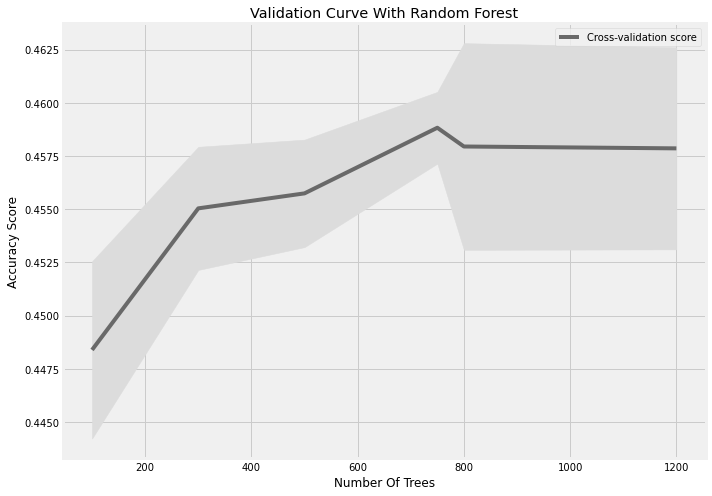

In [246]:
train_mean = np.mean(train_scoreNum, axis=1)
train_std = np.std(train_scoreNum, axis=1)

test_mean = np.mean(test_scoreNum, axis=1)
test_std = np.std(test_scoreNum, axis=1)

plt.subplots(1, figsize=(10,7))
#plt.plot(num_est, train_mean, label="Training score", color="black")
plt.plot(num_est, test_mean, label="Cross-validation score", color="dimgrey")

#plt.fill_between(num_est, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(num_est, test_mean - test_std, test_mean + test_std, color="gainsboro")
 
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

#### max_depth

In [254]:
max_d = [10, 15, 20, 25, 30, 35]
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train, 
                                param_name = 'max_depth', 
                                param_range = max_d, cv = 3, n_jobs = -1)

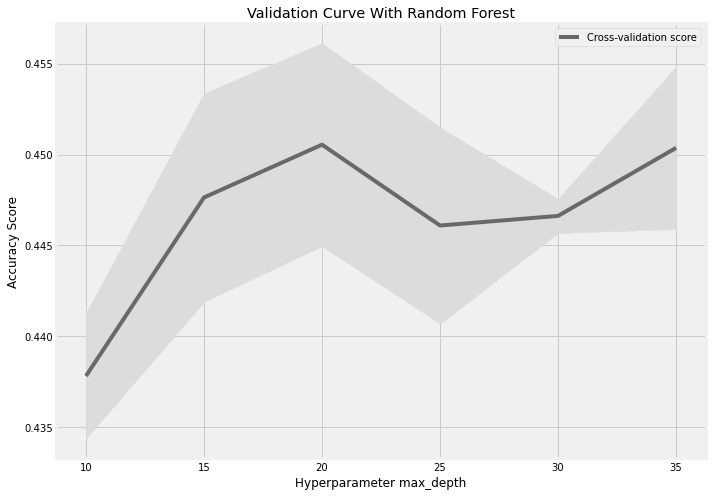

In [255]:
train_mean = np.mean(train_scoreNum, axis=1)
train_std = np.std(train_scoreNum, axis=1)

test_mean = np.mean(test_scoreNum, axis=1)
test_std = np.std(test_scoreNum, axis=1)

plt.subplots(1, figsize=(10,7))
#plt.plot(max_d, train_mean, label="Training score", color="black")
plt.plot(max_d, test_mean, label="Cross-validation score", color="dimgrey")

#plt.fill_between(max_d, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(max_d, test_mean - test_std, test_mean + test_std, color="gainsboro")
 
plt.title("Validation Curve With Random Forest")
plt.xlabel("Hyperparameter max_depth")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

#### max_features

In [256]:
max_f = ['auto', 'sqrt', 'log2']
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train, 
                                param_name = 'max_features', 
                                param_range = max_f, cv = 3, n_jobs = -1)

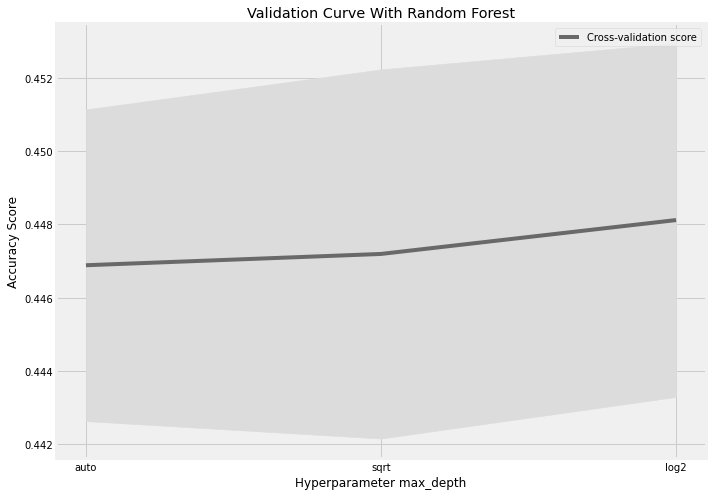

In [258]:
train_mean = np.mean(train_scoreNum, axis=1)
train_std = np.std(train_scoreNum, axis=1)

test_mean = np.mean(test_scoreNum, axis=1)
test_std = np.std(test_scoreNum, axis=1)

plt.subplots(1, figsize=(10,7))
#plt.plot(max_f, train_mean, label="Training score", color="black")
plt.plot(max_f, test_mean, label="Cross-validation score", color="dimgrey")

#plt.fill_between(max_f, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(max_f, test_mean - test_std, test_mean + test_std, color="gainsboro")
 
plt.title("Validation Curve With Random Forest")
plt.xlabel("Hyperparameter max_depth")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

#### min_samples_split

In [273]:
min_ss = [2, 4, 5, 6, 8, 10]
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train, 
                                param_name = 'min_samples_split', 
                                param_range = min_ss, cv = 3, n_jobs = -1)

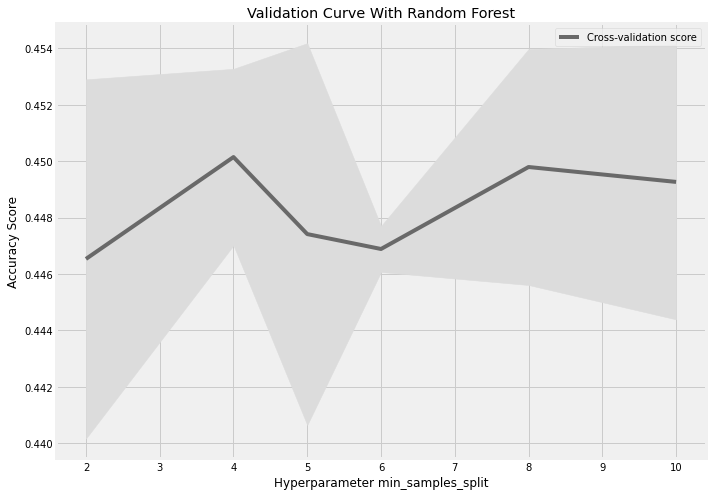

In [274]:
train_mean = np.mean(train_scoreNum, axis=1)
train_std = np.std(train_scoreNum, axis=1)

test_mean = np.mean(test_scoreNum, axis=1)
test_std = np.std(test_scoreNum, axis=1)

plt.subplots(1, figsize=(10,7))
#plt.plot(min_ss, train_mean, label="Training score", color="black")
plt.plot(min_ss, test_mean, label="Cross-validation score", color="dimgrey")

#plt.fill_between(min_ss, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(min_ss, test_mean - test_std, test_mean + test_std, color="gainsboro")
 
plt.title("Validation Curve With Random Forest")
plt.xlabel("Hyperparameter min_samples_split")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

#### min_samples_leaf

In [270]:
min_sl = [2, 4, 6, 8, 10]
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train, 
                                param_name = 'min_samples_leaf', 
                                param_range = min_sl, cv = 3, n_jobs = -1)

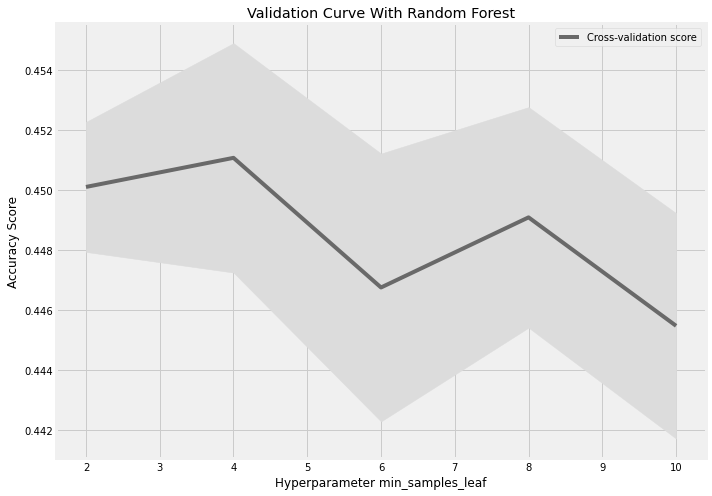

In [271]:
train_mean = np.mean(train_scoreNum, axis=1)
train_std = np.std(train_scoreNum, axis=1)

test_mean = np.mean(test_scoreNum, axis=1)
test_std = np.std(test_scoreNum, axis=1)

plt.subplots(1, figsize=(10,7))
#plt.plot(min_sl, train_mean, label="Training score", color="black")
plt.plot(min_sl, test_mean, label="Cross-validation score", color="dimgrey")

#plt.fill_between(min_sl, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(min_sl, test_mean - test_std, test_mean + test_std, color="gainsboro")
 
plt.title("Validation Curve With Random Forest")
plt.xlabel("Hyperparameter min_samples_leaf")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

In [317]:
#    'max_depth'= 20,
#    'min_samples_leaf'= 4,
#    'min_samples_split' = 4,
#    'n_estimators' = 750
# rerun model using hyperparameter tuning
rf_hyper = RandomForestClassifier(max_depth = 20, min_samples_leaf = 4, 
                                  min_samples_split = 4, n_estimators = 750)

multi_train(rf_hyper, X_train, y_train)

              precision    recall  f1-score   support

       blues       0.41      0.25      0.31       921
     country       0.45      0.57      0.50      1089
     hip hop       0.73      0.51      0.60       181
        jazz       0.53      0.43      0.48       769
         pop       0.43      0.61      0.50      1409
      reggae       0.53      0.45      0.49       499
        rock       0.51      0.37      0.43       807

    accuracy                           0.47      5675
   macro avg       0.51      0.46      0.47      5675
weighted avg       0.48      0.47      0.46      5675

Train accuracy:  0.9436023968981319
Validation accuracy:  0.46766519823788544
              precision    recall  f1-score   support

       blues       0.42      0.24      0.31       921
     country       0.46      0.57      0.51      1089
     hip hop       0.73      0.51      0.60       181
        jazz       0.52      0.43      0.47       769
         pop       0.43      0.61      0.50      1409


0.4669074889867842

In [318]:
rf_hyper_wt = RandomForestClassifier(max_depth = 20, min_samples_leaf = 4, 
                                     min_samples_split = 4, n_estimators = 750, class_weight = 'balanced')

multi_train(rf_hyper_wt, X_train, y_train)

              precision    recall  f1-score   support

       blues       0.39      0.30      0.34       921
     country       0.46      0.59      0.52      1089
     hip hop       0.56      0.64      0.60       181
        jazz       0.48      0.48      0.48       769
         pop       0.51      0.40      0.45      1409
      reggae       0.44      0.62      0.51       499
        rock       0.46      0.45      0.46       807

    accuracy                           0.47      5675
   macro avg       0.47      0.50      0.48      5675
weighted avg       0.47      0.47      0.46      5675

Train accuracy:  0.9373751615556339
Validation accuracy:  0.4650220264317181
              precision    recall  f1-score   support

       blues       0.38      0.29      0.33       921
     country       0.46      0.59      0.52      1089
     hip hop       0.56      0.64      0.59       181
        jazz       0.46      0.47      0.47       769
         pop       0.51      0.40      0.44      1409
 

0.4643171806167401

In [319]:
# hyperparameter tuning helped by 0.013
# but just one hyperparam + class_weight balanced has the best score
# finally run with the test set which hasn't been touched
pred_test = rf_hyper.predict(X_test)
    
print(classification_report(y_test, pred_test))
print(f"Test accuracy:  {accuracy_score(y_test, pred_test)}")
    
rf_hyper.score(X_test, y_test)

              precision    recall  f1-score   support

       blues       0.47      0.29      0.36       921
     country       0.47      0.60      0.53      1089
     hip hop       0.71      0.48      0.57       181
        jazz       0.53      0.40      0.45       769
         pop       0.39      0.58      0.47      1408
      reggae       0.52      0.44      0.48       500
        rock       0.48      0.32      0.38       807

    accuracy                           0.46      5675
   macro avg       0.51      0.44      0.46      5675
weighted avg       0.47      0.46      0.45      5675

Test accuracy:  0.45779735682819384


0.45779735682819384

In [320]:
# but just one hyperparam + class_weight balanced has the best score
pred_test = randomforest_weight.predict(X_test)
    
print(classification_report(y_test, pred_test))
print(f"Test accuracy:  {accuracy_score(y_test, pred_test)}")
    
randomforest_weight.score(X_test, y_test)


              precision    recall  f1-score   support

       blues       0.48      0.30      0.37       921
     country       0.47      0.60      0.53      1089
     hip hop       0.65      0.48      0.55       181
        jazz       0.55      0.41      0.47       769
         pop       0.40      0.56      0.46      1408
      reggae       0.52      0.48      0.50       500
        rock       0.46      0.32      0.38       807

    accuracy                           0.46      5675
   macro avg       0.50      0.45      0.47      5675
weighted avg       0.47      0.46      0.45      5675

Test accuracy:  0.4606167400881057


0.4606167400881057

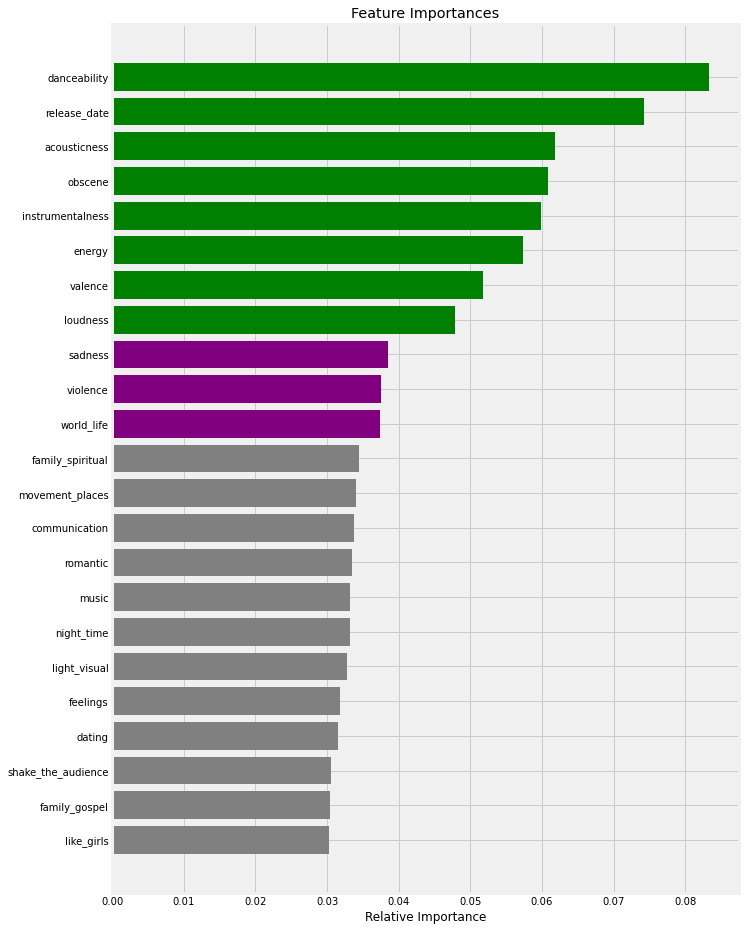

In [322]:
features = X_train.columns
importances = randomforest_weight.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,16))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color=['gray', 'gray', 'gray', 'gray', 'gray', 'gray', 
                                                           'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 
                                                           'purple', 'purple', 'purple', 'green', 'green', 
                                                           'green', 'green', 'green', 'green', 'green', 
                                                           'green'], align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance');

#### Based on above feature importance and the feature/target box plots, remove features to see how they affect the score

In [330]:

rf_hyper2 = RandomForestClassifier(class_weight = 'balanced', n_estimators = 750)

multi_train(rf_hyper2, X_train.drop(columns = ['feelings']), y_train)

              precision    recall  f1-score   support

       blues       0.42      0.26      0.32       921
     country       0.46      0.56      0.51      1089
     hip hop       0.69      0.55      0.61       181
        jazz       0.54      0.45      0.49       769
         pop       0.43      0.58      0.49      1409
      reggae       0.53      0.51      0.52       499
        rock       0.51      0.38      0.44       807

    accuracy                           0.47      5675
   macro avg       0.51      0.47      0.48      5675
weighted avg       0.48      0.47      0.47      5675

Train accuracy:  1.0
Validation accuracy:  0.47295154185022026
              precision    recall  f1-score   support

       blues       0.41      0.26      0.32       921
     country       0.46      0.57      0.51      1089
     hip hop       0.68      0.54      0.60       181
        jazz       0.53      0.45      0.49       769
         pop       0.43      0.58      0.49      1409
      reggae   

0.47067841409691624

In [332]:
# but just one hyperparam + class_weight balanced has the best score
pred_test = rf_hyper2.predict(X_test.drop(columns = ['feelings']))
    
print(classification_report(y_test, pred_test))
print(f"Test accuracy:  {accuracy_score(y_test, pred_test)}")
    
rf_hyper2.score(X_test.drop(columns = ['feelings']), y_test)

              precision    recall  f1-score   support

       blues       0.47      0.30      0.36       921
     country       0.46      0.59      0.52      1089
     hip hop       0.65      0.49      0.56       181
        jazz       0.53      0.40      0.46       769
         pop       0.40      0.56      0.47      1408
      reggae       0.52      0.46      0.49       500
        rock       0.47      0.33      0.39       807

    accuracy                           0.46      5675
   macro avg       0.50      0.45      0.46      5675
weighted avg       0.47      0.46      0.45      5675

Test accuracy:  0.4588546255506608


0.4588546255506608

In [328]:
multi_train(randomforest_weight, X_train.drop(columns = ['feelings', 'shake_the_audience']), y_train)

              precision    recall  f1-score   support

       blues       0.42      0.27      0.33       921
     country       0.47      0.57      0.51      1089
     hip hop       0.68      0.55      0.61       181
        jazz       0.53      0.45      0.49       769
         pop       0.43      0.57      0.49      1409
      reggae       0.53      0.49      0.51       499
        rock       0.51      0.38      0.43       807

    accuracy                           0.47      5675
   macro avg       0.51      0.47      0.48      5675
weighted avg       0.48      0.47      0.47      5675

Train accuracy:  1.0
Validation accuracy:  0.4718942731277533
              precision    recall  f1-score   support

       blues       0.43      0.26      0.32       921
     country       0.46      0.58      0.51      1089
     hip hop       0.67      0.54      0.60       181
        jazz       0.53      0.45      0.48       769
         pop       0.43      0.58      0.50      1409
      reggae    

0.47092511013215865

In [325]:
multi_train(randomforest_weight, X_train.drop(columns = ['feelings', 'family_gospel', 'shake_the_audience']), y_train)

              precision    recall  f1-score   support

       blues       0.42      0.27      0.33       921
     country       0.45      0.57      0.50      1089
     hip hop       0.68      0.54      0.60       181
        jazz       0.53      0.45      0.49       769
         pop       0.43      0.56      0.49      1409
      reggae       0.52      0.50      0.51       499
        rock       0.51      0.38      0.44       807

    accuracy                           0.47      5675
   macro avg       0.51      0.47      0.48      5675
weighted avg       0.47      0.47      0.46      5675

Train accuracy:  1.0
Validation accuracy:  0.46960352422907486
              precision    recall  f1-score   support

       blues       0.42      0.26      0.32       921
     country       0.46      0.57      0.51      1089
     hip hop       0.67      0.53      0.59       181
        jazz       0.54      0.45      0.49       769
         pop       0.43      0.58      0.49      1409
      reggae   

0.470273127753304

In [326]:
multi_train(randomforest_weight, 
            X_train.drop(columns = ['feelings', 'family_gospel', 'shake_the_audience', 'like_girls']), 
            y_train)

              precision    recall  f1-score   support

       blues       0.42      0.28      0.33       921
     country       0.45      0.56      0.50      1089
     hip hop       0.66      0.54      0.59       181
        jazz       0.53      0.45      0.49       769
         pop       0.43      0.57      0.49      1409
      reggae       0.52      0.48      0.50       499
        rock       0.52      0.39      0.44       807

    accuracy                           0.47      5675
   macro avg       0.50      0.47      0.48      5675
weighted avg       0.47      0.47      0.46      5675

Train accuracy:  1.0
Validation accuracy:  0.4701321585903084
              precision    recall  f1-score   support

       blues       0.41      0.26      0.32       921
     country       0.46      0.56      0.50      1089
     hip hop       0.67      0.53      0.59       181
        jazz       0.53      0.45      0.49       769
         pop       0.43      0.57      0.49      1409
      reggae    

0.4693920704845815

In [327]:
multi_train(randomforest_weight, 
            X_train.drop(columns = ['feelings', 'family_gospel', 'shake_the_audience', 'like_girls', 'dating']), 
            y_train)

              precision    recall  f1-score   support

       blues       0.41      0.26      0.32       921
     country       0.45      0.57      0.50      1089
     hip hop       0.65      0.53      0.59       181
        jazz       0.52      0.45      0.48       769
         pop       0.43      0.56      0.49      1409
      reggae       0.52      0.49      0.50       499
        rock       0.49      0.37      0.42       807

    accuracy                           0.47      5675
   macro avg       0.50      0.46      0.47      5675
weighted avg       0.47      0.47      0.46      5675

Train accuracy:  1.0
Validation accuracy:  0.4650220264317181
              precision    recall  f1-score   support

       blues       0.40      0.27      0.33       921
     country       0.45      0.57      0.51      1089
     hip hop       0.66      0.54      0.59       181
        jazz       0.53      0.45      0.49       769
         pop       0.44      0.57      0.50      1409
      reggae    

0.46725991189427313